In [1]:
import scipy.io
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras import Sequential, models, Model
from tensorflow.keras.utils import plot_model, array_to_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tinymlgen import port
import matplotlib.pyplot as plt
from PIL import Image

2023-12-18 08:26:02.662421: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 08:26:03.006377: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 08:26:03.006432: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 08:26:03.008431: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 08:26:03.179155: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 08:26:03.181011: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
#as the labels are text, we have used label_encoder function to translate them into numbers
#classes is a dictionary, key is the number and value is the name of the road sign
x = np.load('x_low_gray.npy')
y = np.load('y_low_gray.npy')
print(np.shape(x))
print(np.shape(y))
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)
decoded_y = label_encoder.inverse_transform(encoded_y)
classes = dict(zip(encoded_y, decoded_y)) # a dict is defined
label_encoder.classes_ = classes
print('Classifications in Dict format:',classes)
print('Number of classifications:',len(classes))
classes_txt = np.array([np.array(v) for v in classes.values()])
print('Classifications in text format:',classes_txt)


(1916, 28, 28)
(1916,)
Classifications in Dict format: {17: 'PRIORITY_ROAD', 13: 'PASS_EITHER_SIDE', 15: 'PASS_RIGHT_SIDE', 9: 'GIVE_WAY', 6: '70_SIGN', 8: '90_SIGN', 12: 'OTHER', 7: '80_SIGN', 4: '50_SIGN', 16: 'PEDESTRIAN_CROSSING', 5: '60_SIGN', 3: '30_SIGN', 10: 'NO_PARKING', 14: 'PASS_LEFT_SIDE', 1: '110_SIGN', 18: 'STOP', 0: '100_SIGN', 11: 'NO_STOPPING_NO_STANDING', 2: '120_SIGN', 19: 'URDBL'}
Number of classifications: 20
Classifications in text format: ['PRIORITY_ROAD' 'PASS_EITHER_SIDE' 'PASS_RIGHT_SIDE' 'GIVE_WAY' '70_SIGN'
 '90_SIGN' 'OTHER' '80_SIGN' '50_SIGN' 'PEDESTRIAN_CROSSING' '60_SIGN'
 '30_SIGN' 'NO_PARKING' 'PASS_LEFT_SIDE' '110_SIGN' 'STOP' '100_SIGN'
 'NO_STOPPING_NO_STANDING' '120_SIGN' 'URDBL']


In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, encoded_y, test_size=0.2, random_state=4)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=4)
#print("size of x_train is ", np.shape(x_train))
#print("size of x_test is ", np.shape(x_test))
#print("size of x_val is ", np.shape(x_val))


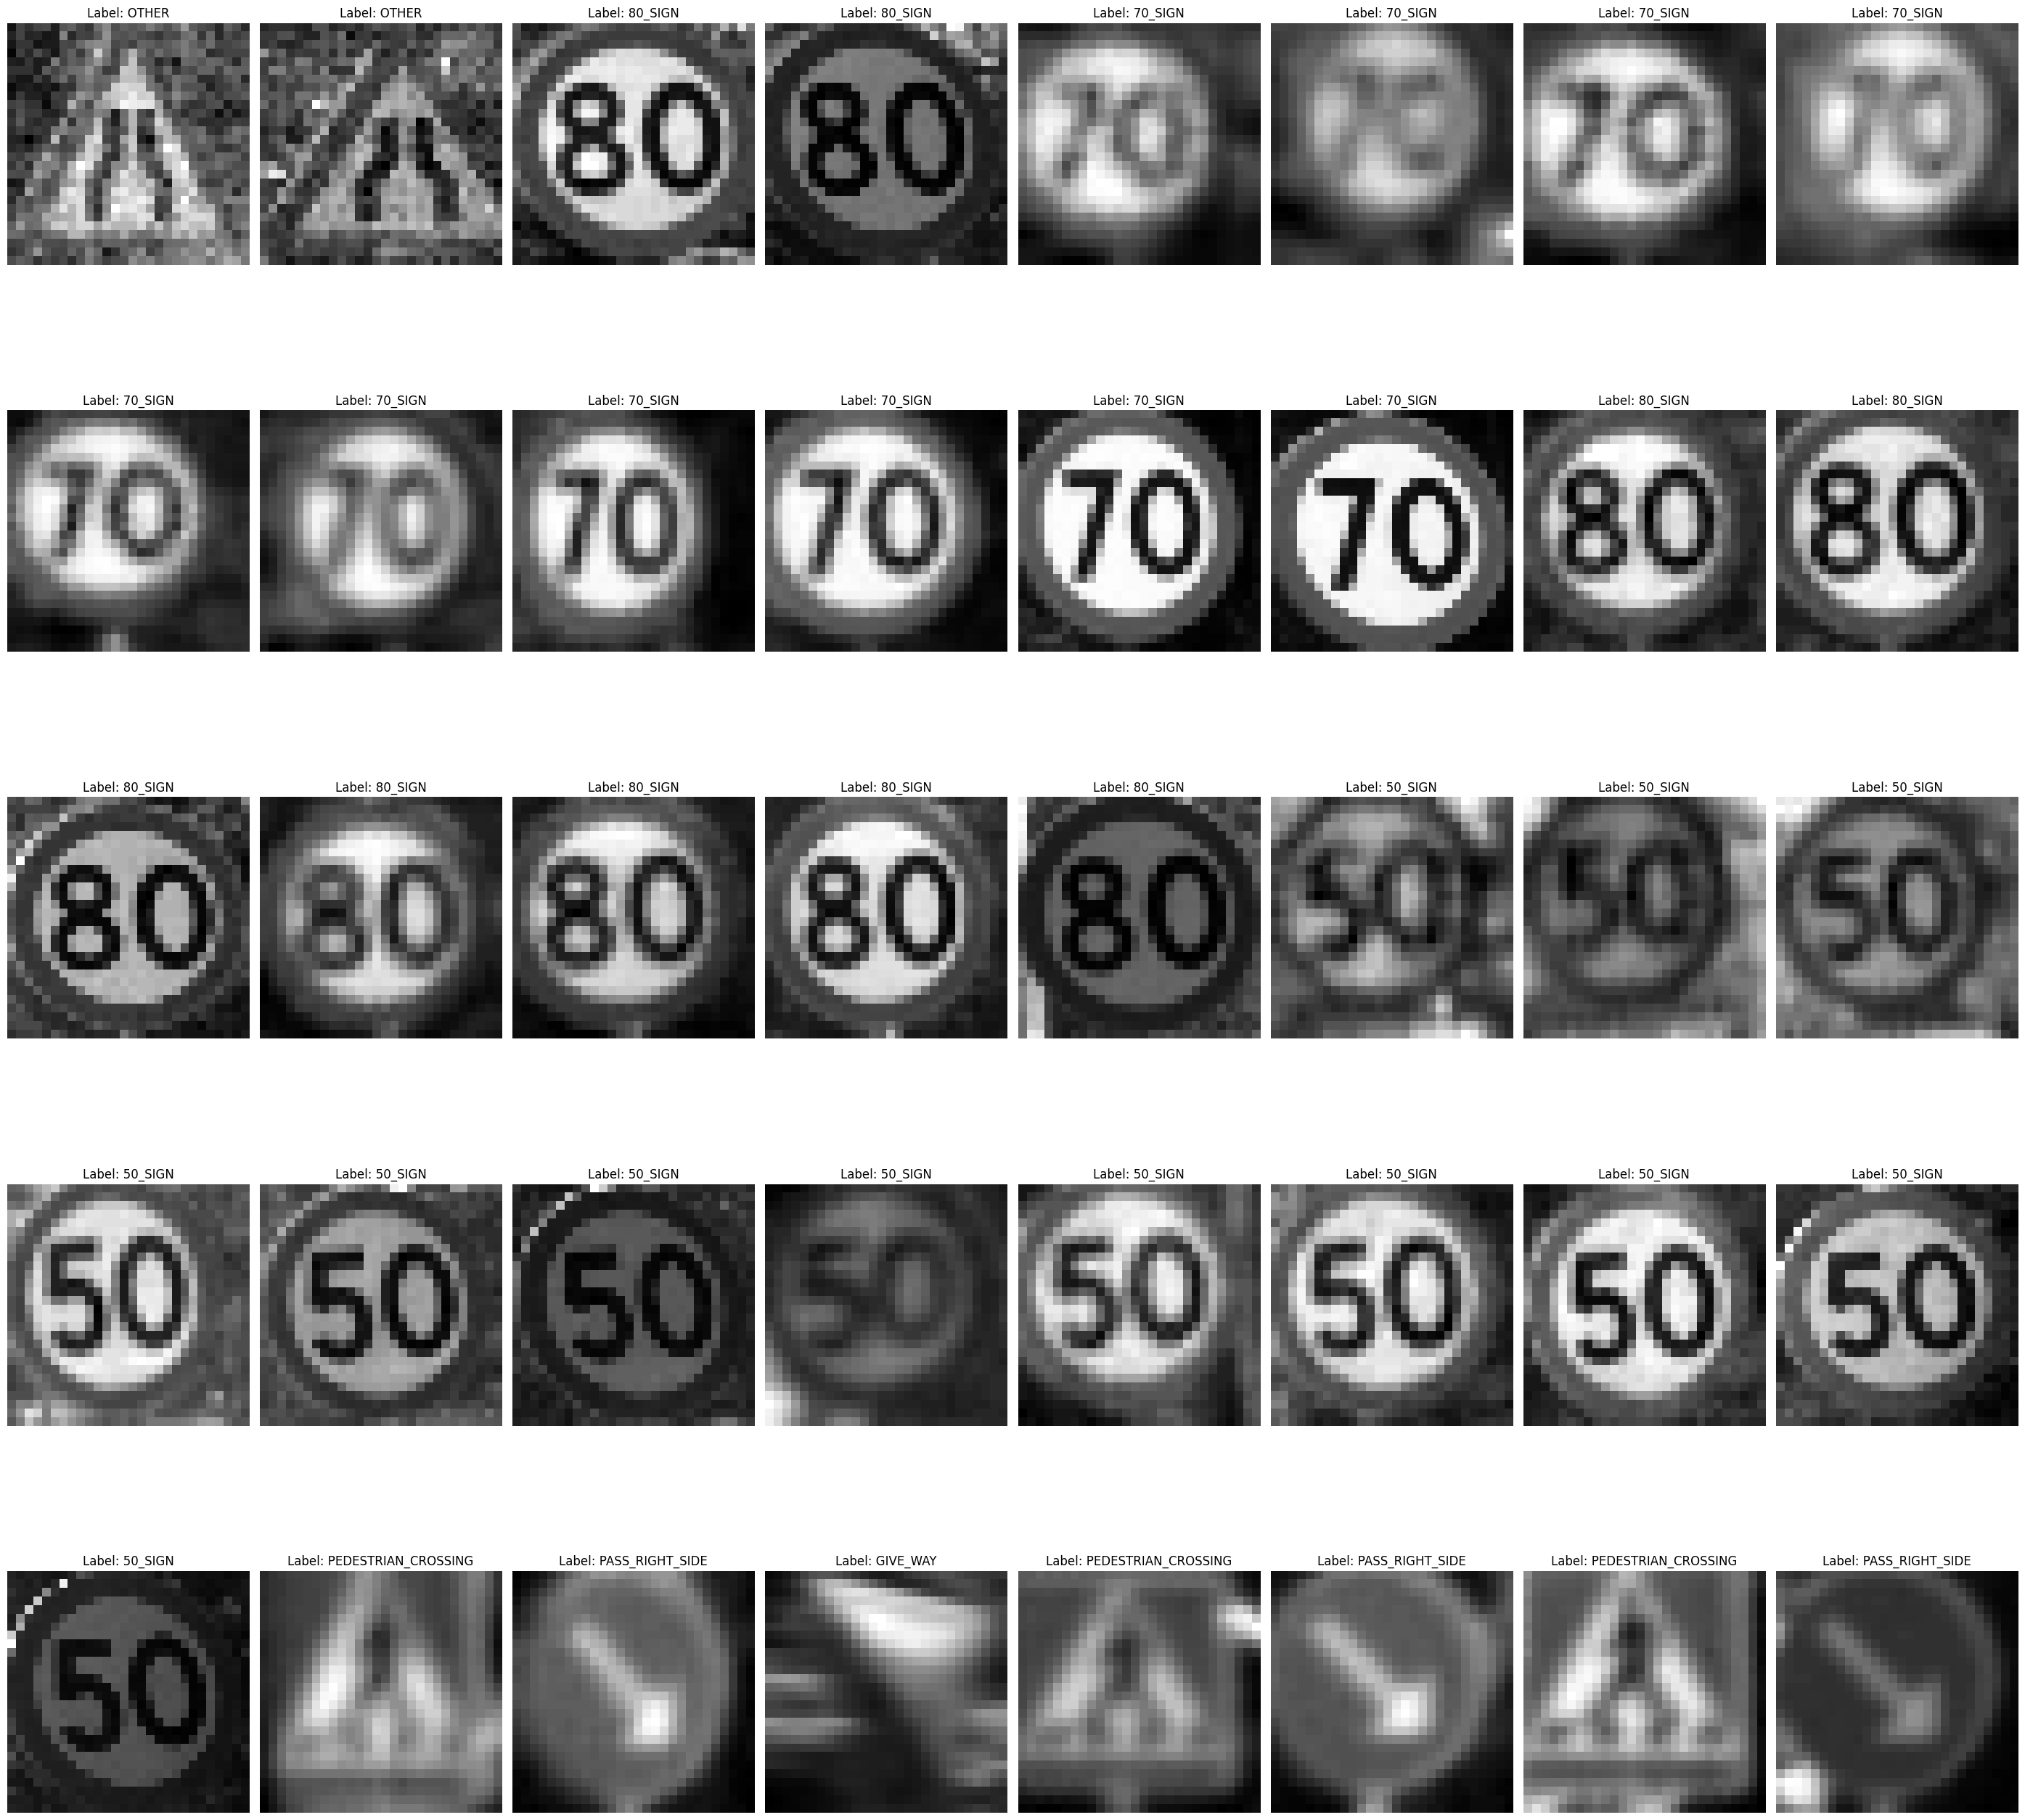

In [4]:

# Display images in subplots
num_rows = 5
num_cols = 8
total_images = num_rows * num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(28, 28))

for i in range(total_images):
    if i < len(x):
        image = x[i+50]
        label = y[i+50]
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(image, cmap='gray') 
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    else:
        axes[i // num_cols, i % num_cols].axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()


In [5]:
# dataset reshape
x_train = x_train.reshape((-1, x_train.shape[1], x_train.shape[2], 1))
print("Now, size of x_train is ", np.shape(x_train))

x_test = x_test.reshape((-1, x_test.shape[1], x_test.shape[2], 1))
print("Now, size of x_test is ", np.shape(x_test))

x_val = x_val.reshape((-1, x_val.shape[1], x_val.shape[2], 1))
print("Now, size of x_train is ", np.shape(x_val))




Now, size of x_train is  (1378, 28, 28, 1)
Now, size of x_test is  (384, 28, 28, 1)
Now, size of x_train is  (154, 28, 28, 1)


In [6]:
model_final = Sequential([
    
    Conv2D(8, (3,3), activation='relu', input_shape=x_train.shape[1:]),
    MaxPool2D((3, 3)),
    Conv2D(16, (2,2), activation='relu'),
    MaxPool2D((3, 3)),    
    #Conv2D(8, (2,2), activation='relu'),
    #MaxPool2D((2, 2)),
    
    Flatten(),

    Dense(75, activation='relu', name = 'dense_0'),
    Dropout(0.2),
    #Dynamic layers
    Dense(35, activation='relu', name = 'dense_1'),
    Dense(30, activation='relu', name = 'dense_2'),
    Dense(20, activation='softmax', name = 'dense_3') # probability
])

model_final.summary()
num_dynamic_layers = 3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 8, 8)           0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          528       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_0 (Dense)             (None, 75)                4

In [7]:
# define loss function and optimizer
model_final.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit the model
history = model_final.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=30, verbose=2)
loss, accuracy = model_final.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy: {accuracy*100}')

Epoch 1/50
46/46 - 2s - loss: 9.6840 - accuracy: 0.0682 - val_loss: 2.8721 - val_accuracy: 0.1299 - 2s/epoch - 44ms/step
Epoch 2/50
46/46 - 0s - loss: 2.8313 - accuracy: 0.1597 - val_loss: 2.5733 - val_accuracy: 0.2338 - 355ms/epoch - 8ms/step
Epoch 3/50
46/46 - 0s - loss: 2.6025 - accuracy: 0.1981 - val_loss: 2.4976 - val_accuracy: 0.2922 - 323ms/epoch - 7ms/step
Epoch 4/50
46/46 - 0s - loss: 2.4585 - accuracy: 0.2598 - val_loss: 2.3890 - val_accuracy: 0.3571 - 326ms/epoch - 7ms/step
Epoch 5/50
46/46 - 0s - loss: 2.3188 - accuracy: 0.3120 - val_loss: 2.2397 - val_accuracy: 0.4091 - 331ms/epoch - 7ms/step
Epoch 6/50
46/46 - 0s - loss: 2.1607 - accuracy: 0.3766 - val_loss: 2.0326 - val_accuracy: 0.4805 - 324ms/epoch - 7ms/step
Epoch 7/50
46/46 - 0s - loss: 1.9994 - accuracy: 0.4282 - val_loss: 1.8633 - val_accuracy: 0.5000 - 325ms/epoch - 7ms/step
Epoch 8/50
46/46 - 0s - loss: 1.8267 - accuracy: 0.4927 - val_loss: 1.6567 - val_accuracy: 0.5519 - 370ms/epoch - 8ms/step
Epoch 9/50
46/46 -

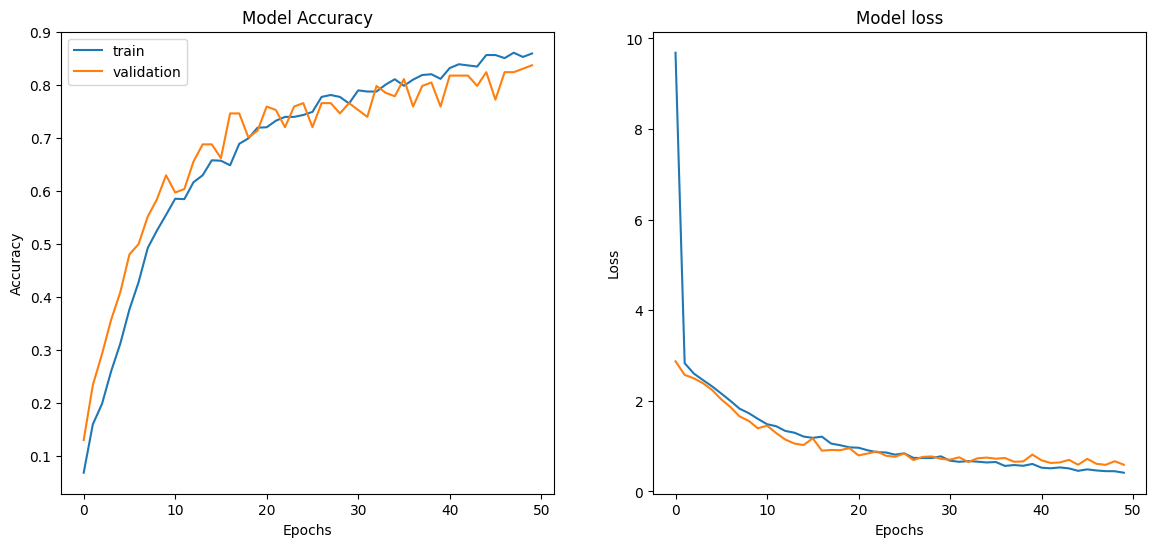

In [8]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="validation")

4
Predicted label: 50_SIGN


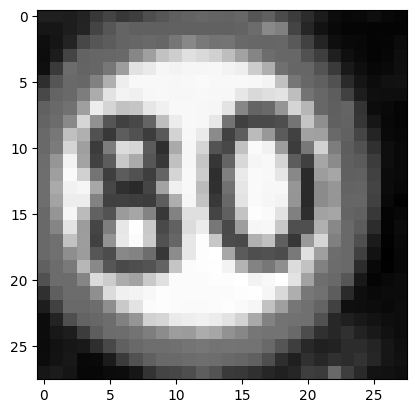

In [9]:
# input an image from x_val to test if the model works fine
image_index = 11
plt.imshow(np.squeeze(x_val[image_index]), cmap='gray')
# make a prediction
yhat = model_final.predict([np.expand_dims(x_val[image_index], axis=0)], verbose = 0)
result = np.argmax(yhat)
print(result)
value = classes.get(result)
print('Predicted label: {}'.format(value))

In [10]:
# # to test the model with a random image from the internet
# image = Image.open('C:\\Users\\poori\\OneDrive\\Desktop\\pd.jpg')
# input_shape = (28, 28)
# image = image.resize(input_shape)  # Resize the image to match the model's input size
# grayscale_image = image.convert('L')
# input_data = tf.keras.preprocessing.image.img_to_array(grayscale_image)
# input_data = tf.expand_dims(input_data, axis=0)
# #input_data = tf.keras.applications.mobilenet.preprocess_input(input_data)  # Preprocess according to your model

# yhat = model_final.predict(input_data)
# result = np.argmax(yhat)
# print(result)
# value = classes.get(result)
# print('Predicted label: {}'.format(value))
# plt.imshow(grayscale_image, cmap='gray')


In [11]:
# to save the model
model_final.save("model_final")

INFO:tensorflow:Assets written to: model_final/assets


INFO:tensorflow:Assets written to: model_final/assets


In [12]:
model = models.load_model('model_final')


x = model.layers[-(num_dynamic_layers + 1)].output 

model = Model(inputs = model.input, outputs = x)
model.summary()

# output contains input vector to DNN
cnn_pred_train = model.predict(x_train) 
cnn_pred_validation = model.predict(x_val) # need to transform validation to input vector for DNN
cnn_pred_test = model.predict(x_test) # perhaps merge with validation for Arduino

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 8, 8)           0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          528       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0     

In [24]:
# Save output from pretrained model (CNN) to .h, is also used below
first_layer_input_cnt = len(cnn_pred_train[0])

bias = 8

def append_photo_data(data, data_cnt, type, lines):
    lines.append("const float " + type + "_data[" + str(data_cnt) + "][" + str(first_layer_input_cnt) + "] = {")
    frames_str = []
    for frame in data:
        frame_values = [str(i) for i in frame]
        frames_str.append("  {" + ", ".join(frame_values) + "}")
    lines.append(",\n".join(frames_str))
    lines.append("};")
    lines.append("")

def append_label_data(data, data_cnt, type, lines):
    lines.append("const int " + type + "_labels[" + str(data_cnt) + "] = {")
    labels_str = [str(i) for i in data if i < bias]
    lines.append("  " + ", ".join(labels_str))
    lines.append("};")
    lines.append("")

def append_class_data(data, data_cnt, lines):
    lines.append("const char* classes[" + str(data_cnt) + "] = {")
    classes_str = ['"' + str(i) + '"' for i in data]
    lines.append("  " + ", ".join(classes_str))
    lines.append("};")
    lines.append("")



def output_dataset(cnn_pred_train, y_train, file_suffix):
    train_data_cnt = len(y_train)
    validation_data_cnt = len(y_val)
    test_data_cnt = len(y_test)
    classes_cnt = len(classes)  
    lines = []
    lines.append("const int first_layer_input_cnt = " + str(first_layer_input_cnt) + ";")
    lines.append("const int train_data_cnt = " + str(train_data_cnt) + ";")
    lines.append("const int validation_data_cnt = " + str(validation_data_cnt) + ";")
    lines.append("const int test_data_cnt = " + str(test_data_cnt) + ";")
    lines.append("const int classes_cnt = " + str(classes_cnt) + ";")
    lines.append("")

    append_class_data(classes_txt, classes_cnt, lines)

    # Training labels
    append_label_data(y_train, train_data_cnt, "train", lines)

    # Validation labels
    append_label_data(y_val, validation_data_cnt, "validation", lines)

    # Test labels
    append_label_data(y_test, test_data_cnt, "test", lines)

    # Training data
    append_photo_data(cnn_pred_train, train_data_cnt, "train", lines)

    # Validation data
    append_photo_data(cnn_pred_validation, validation_data_cnt, "validation", lines)

    # Test data
    append_photo_data(cnn_pred_test, test_data_cnt, "test", lines)

    f = open("cnn_data" + file_suffix + ".h", "w")
    f.write("\n".join(lines))
    f.close()

# Total, unbiasad data-set
output_dataset(cnn_pred_train, y_train, "")


In [23]:
# Save output from pretrained model (CNN) to .h, is also used below
first_layer_input_cnt = len(cnn_pred_train[0])

bias = 3

def append_photo_data(data, data_cnt, type, lines):
    lines.append("const float " + type + "_data[" + str(data_cnt) + "][" + str(first_layer_input_cnt) + "] = {")
    frames_str = []
    for frame in data:
        frame_values = [str(i) for i in frame]
        frames_str.append("  {" + ", ".join(frame_values) + "}")
    lines.append(",\n".join(frames_str))
    lines.append("};")
    lines.append("")

def append_label_data(data, data_cnt, type, lines):
    lines.append("const int " + type + "_labels[" + str(data_cnt) + "] = {")
    labels_str = [str(i) for i in data]
    lines.append("  " + ", ".join(labels_str))
    lines.append("};")
    lines.append("")

def append_class_data(data, data_cnt, lines):
    lines.append("const char* classes[" + str(data_cnt) + "] = {")
    classes_str = ['"' + str(i) + '"' for i in data]
    lines.append("  " + ", ".join(classes_str))
    lines.append("};")
    lines.append("")



def output_dataset(cnn_pred_train, y_train, file_suffix):
    train_data_cnt = len([y for y in y_train if y < bias])
    validation_data_cnt = len([y for y in y_val if y < bias])
    test_data_cnt = len(y_test)
    classes_cnt = len(classes)

    

    lines = []
    lines.append("const int first_layer_input_cnt = " + str(first_layer_input_cnt) + ";")
    lines.append("const int train_data_cnt = " + str(train_data_cnt) + ";")
    lines.append("const int validation_data_cnt = " + str(validation_data_cnt) + ";")
    lines.append("const int test_data_cnt = " + str(test_data_cnt) + ";")
    lines.append("const int classes_cnt = " + str(classes_cnt) + ";")
    lines.append("")

    append_class_data(classes_txt, classes_cnt, lines)

    # Training labels
    append_label_data([y for y in y_train if y < bias], train_data_cnt, "train", lines)

    # Validation labels
    append_label_data([y for y in y_val if y < bias], validation_data_cnt, "validation", lines)

    # Test labels
    append_label_data(y_test, test_data_cnt, "test", lines)

    # Training data
    append_photo_data([cnn_pred_train[i] for i in range(0,len(cnn_pred_train))
                       if y_train[i] < bias], train_data_cnt, "train", lines)

    # Validation data
    append_photo_data([cnn_pred_validation[i] for i in range(0,len(cnn_pred_validation))
                       if y_val[i] < bias], validation_data_cnt, "validation", lines)

    # Test data
    append_photo_data(cnn_pred_test, test_data_cnt, "test", lines)

    f = open("cnn_data" + file_suffix + ".h", "w")
    f.write("\n".join(lines))
    f.close()



output_dataset(cnn_pred_train, y_train, "")


In [15]:
# Creating the DNN model, by extracting part from above
model_final_copy = models.clone_model(model_final)

in_layer = model_final_copy.layers[-(num_dynamic_layers + 1)].output
out_layer = model_final_copy.layers[-1].output 

dnn_model = Model(inputs = in_layer, outputs = out_layer)
dnn_model.summary()
dnn_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#dnn_pred_train = dnn_model.predict(cnn_pred_train)
#print(dnn_pred_train)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75)]              0         
                                                                 
 dense_1 (Dense)             (None, 35)                2660      
                                                                 
 dense_2 (Dense)             (None, 30)                1080      
                                                                 
 dense_3 (Dense)             (None, 20)                620       
                                                                 
Total params: 4360 (17.03 KB)
Trainable params: 4360 (17.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# evaluate the untrained DNN model
def print_dnn_accuracy(input, labels, name, verbose=False):
    y_pred_class = dnn_model.predict(input)
    y_pred_class = np.argmax(np.array(y_pred_class), axis=1)

    y_diff = y_pred_class != labels
    print(name, "acc:", 1 - y_diff.sum() / len(y_diff))

    y_pred_txt = []
    y_true_txt = []

    for i in range(len(input)):
        y_pred_txt.append(classes_txt[y_pred_class[i]])
        y_true_txt.append(classes_txt[labels[i]])

    for i in range(len(y_diff)):
        if y_diff[i] and verbose:
            #plt.imshow(keras.utils.array_to_img(input[i]))
            print(" Is:", y_true_txt[i], "but was predicted as:", y_pred_txt[i])

print_dnn_accuracy(cnn_pred_train, y_train, "Train")
print_dnn_accuracy(cnn_pred_validation, y_val, "Validation")
print_dnn_accuracy(cnn_pred_test, y_test, "Test")

44/44 [==============================] - 0s 2ms/step
Train acc: 0.06458635703918725
5/5 [==============================] - 0s 2ms/step
Validation acc: 0.051948051948051965
12/12 [==============================] - 0s 2ms/step
Test acc: 0.05729166666666663


In [17]:
history_dnn = dnn_model.fit(cnn_pred_train, y_train, validation_data=(cnn_pred_validation, y_val), batch_size=5, epochs=10)

Epoch 1/10
276/276 [==============================] - 1s 3ms/step - loss: 1.7596 - accuracy: 0.5668 - val_loss: 1.3124 - val_accuracy: 0.7078
Epoch 2/10
276/276 [==============================] - 1s 2ms/step - loss: 0.9665 - accuracy: 0.7554 - val_loss: 0.9889 - val_accuracy: 0.7597
Epoch 3/10
276/276 [==============================] - 1s 2ms/step - loss: 0.7192 - accuracy: 0.8099 - val_loss: 0.9774 - val_accuracy: 0.7208
Epoch 4/10
276/276 [==============================] - 1s 2ms/step - loss: 0.5740 - accuracy: 0.8374 - val_loss: 0.8691 - val_accuracy: 0.7597
Epoch 5/10
276/276 [==============================] - 1s 2ms/step - loss: 0.4690 - accuracy: 0.8694 - val_loss: 0.8392 - val_accuracy: 0.7857
Epoch 6/10
276/276 [==============================] - 1s 2ms/step - loss: 0.4106 - accuracy: 0.8897 - val_loss: 0.8666 - val_accuracy: 0.7857
Epoch 7/10
276/276 [==============================] - 1s 2ms/step - loss: 0.3610 - accuracy: 0.9028 - val_loss: 0.8782 - val_accuracy: 0.8052
Epoch 

In [18]:
# Evaluation of the trained model
print_dnn_accuracy(cnn_pred_train, y_train, "Train", True)
print_dnn_accuracy(cnn_pred_validation, y_val, "Validation", True)
print_dnn_accuracy(cnn_pred_test, y_test, "Test", True)

44/44 [==============================] - 0s 2ms/step
Train acc: 0.9383164005805515
 Is: OTHER but was predicted as: PASS_EITHER_SIDE
 Is: 110_SIGN but was predicted as: PASS_EITHER_SIDE
 Is: 70_SIGN but was predicted as: NO_PARKING
 Is: OTHER but was predicted as: NO_PARKING
 Is: NO_STOPPING_NO_STANDING but was predicted as: STOP
 Is: OTHER but was predicted as: PASS_EITHER_SIDE
 Is: PRIORITY_ROAD but was predicted as: OTHER
 Is: 70_SIGN but was predicted as: NO_PARKING
 Is: 70_SIGN but was predicted as: NO_PARKING
 Is: OTHER but was predicted as: PASS_EITHER_SIDE
 Is: PEDESTRIAN_CROSSING but was predicted as: NO_PARKING
 Is: PEDESTRIAN_CROSSING but was predicted as: NO_PARKING
 Is: 70_SIGN but was predicted as: 60_SIGN
 Is: 70_SIGN but was predicted as: GIVE_WAY
 Is: GIVE_WAY but was predicted as: NO_PARKING
 Is: GIVE_WAY but was predicted as: NO_PARKING
 Is: 70_SIGN but was predicted as: NO_PARKING
 Is: 60_SIGN but was predicted as: NO_PARKING
 Is: OTHER but was predicted as: NO_STOP

In [19]:
c_code = port(model, variable_name='road_sign_detection', pretty_print=True,optimize=False)
filename = 'road.h'
with open(filename,'w') as f: 
    f.write(c_code)

INFO:tensorflow:Assets written to: /tmp/tmpacbe2dq2/assets


INFO:tensorflow:Assets written to: /tmp/tmpacbe2dq2/assets
2023-12-18 08:26:43.441050: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-18 08:26:43.441092: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-18 08:26:43.442020: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpacbe2dq2
2023-12-18 08:26:43.443614: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-18 08:26:43.443661: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpacbe2dq2
2023-12-18 08:26:43.447342: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-12-18 08:26:43.448307: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-18 08:26:43.474960: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

In [20]:
#Lite converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open('./modellite.tflite','wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp3p0q0qpj/assets


INFO:tensorflow:Assets written to: /tmp/tmp3p0q0qpj/assets
2023-12-18 08:26:44.549932: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-18 08:26:44.549983: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-18 08:26:44.550321: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3p0q0qpj
2023-12-18 08:26:44.551537: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-18 08:26:44.551587: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3p0q0qpj
2023-12-18 08:26:44.554546: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-18 08:26:44.577798: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp3p0q0qpj
2023-12-18 08:26:44.588335: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

10320